In [1]:
# install.packages("dplyr")
# install.packages("caret")
# install.packages("caTools")
# install.packages("parsnip")
# install.packages("broom")
# install.packages("corrplot")
# install.packages("ggplot2")
# install.packages("gridExtra")

In [1]:
library(dplyr)
library(caret)
library(caTools)
library(parsnip)
library(broom)
library(corrplot)
library(ggplot2)
library(gridExtra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice

corrplot 0.92 loaded


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
dataset <- read.csv("./dataset.csv", header = TRUE)

In [3]:
# Basic summarizations
dim(dataset)
head(dataset)

[1] 1470   35

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


In [4]:
# Removing obvious useless columns
dataset$EmployeeNumber <- NULL
dataset$StandardHours <- NULL
dataset$Over18 <- NULL
dataset$EmployeeCount <- NULL

In [37]:
# Splitting the dataset into the Training set and Test set
model_dataset <- dataset

model_dataset$TotalWorkingYears <- NULL
model_dataset$MonthlyIncome <- NULL
model_dataset$JobLevel <- NULL
model_dataset$YearsWithCurrManager <- NULL
model_dataset$YearsAtCompany <- NULL
model_dataset$YearsInCurrentRole <- NULL
model_dataset$PerformanceRating <- NULL

model_dataset$Attrition <- ifelse(model_dataset$Attrition == "Yes", 1, 0)
model_dataset$Attrition <- as.factor(model_dataset$Attrition)

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


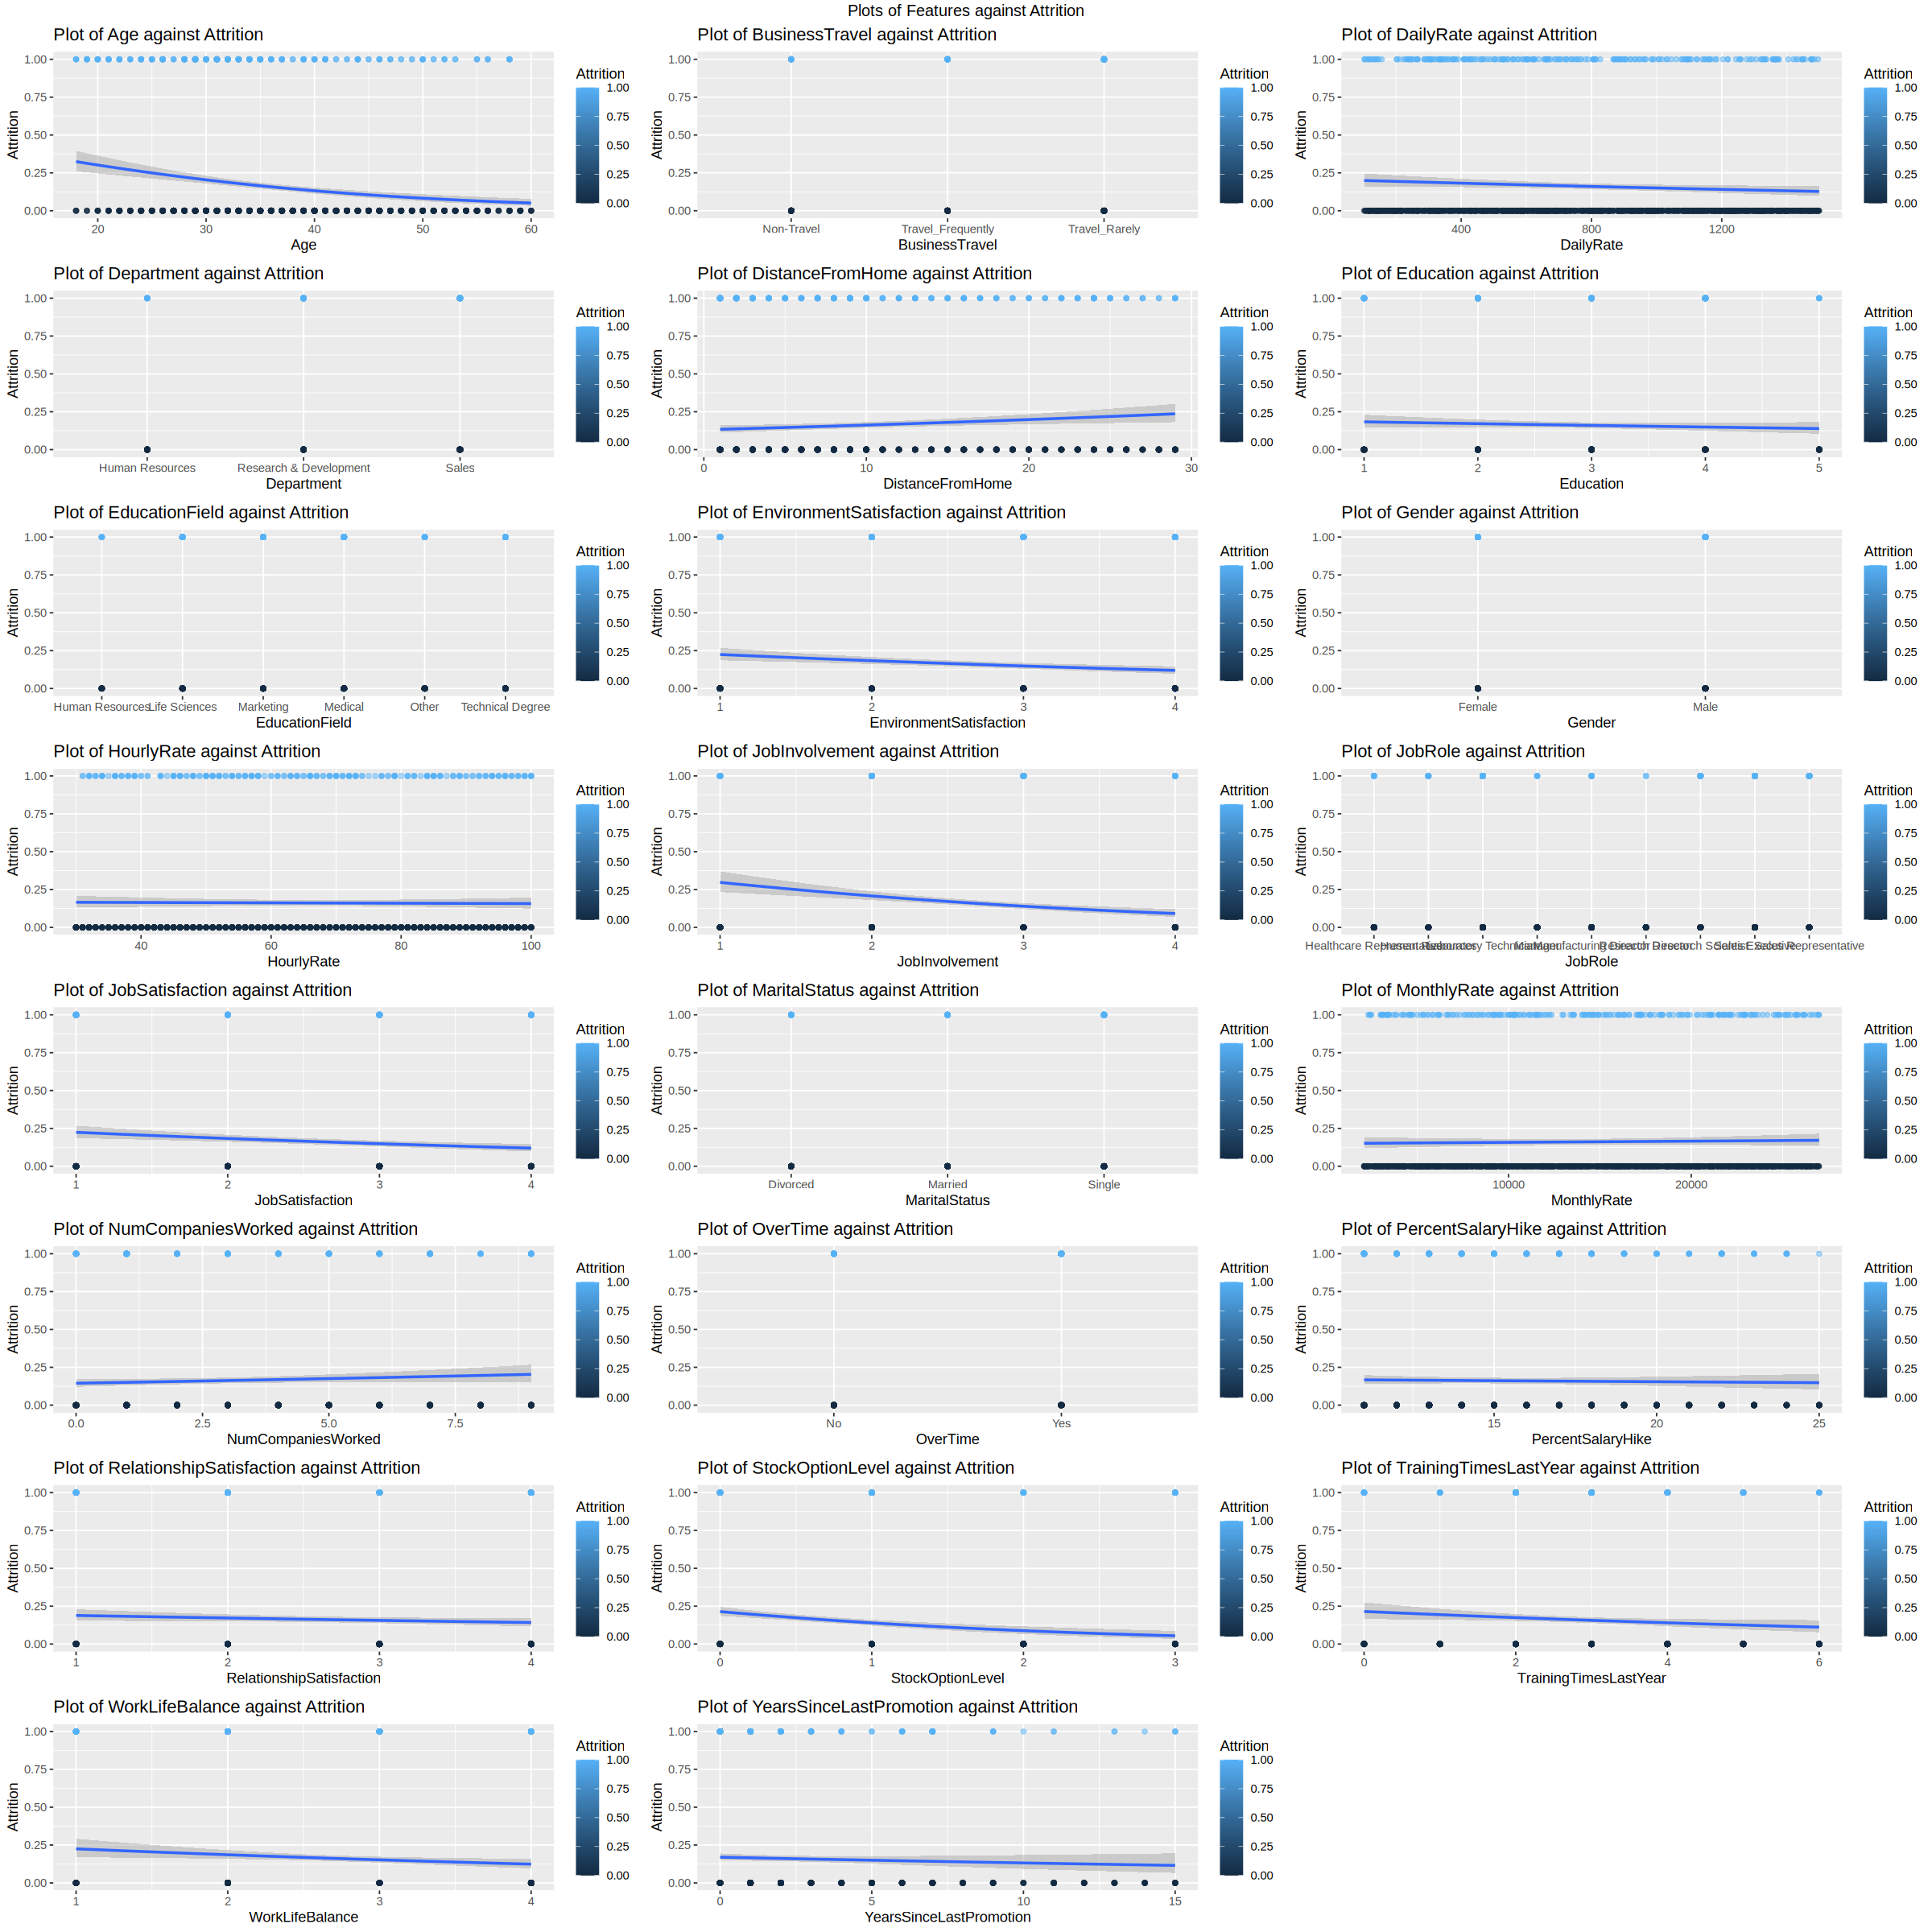

In [7]:
plot_test_set <- model_dataset
# sum(ifelse(plot_test_set$Attrition == 1 | plot_test_set$Attrition == 0, 0, 1))

plot_test_set$Attrition <- as.numeric(plot_test_set$Attrition) - 1
# unique(plot_test_set$Attrition)

library(gridExtra)

plots <- list()

for (feature in names(plot_test_set)) {
  if (feature != "Attrition") {
    plot <- ggplot(plot_test_set, aes_string(x = feature, y = "Attrition")) +
      geom_point(aes(color = Attrition), alpha = 0.5) +
      geom_smooth(method = "glm", method.args = list(family = "binomial"), formula = y ~ x) +
      labs(title = paste("Plot of", feature, "against Attrition"))
    
    plots[[feature]] <- plot
  }
}

options(repr.plot.width=20, repr.plot.height=20)

grid.arrange(grobs = plots, ncol = 3, top = "Plots of Features against Attrition")


In [38]:
# Removing unencodable columns


# lable encoding data
model_dataset$OverTime <- recode(model_dataset$OverTime, "Yes" = 1, "No" = 0)
model_dataset$BusinessTravel <- recode(model_dataset$BusinessTravel, "Non-Travel" = 0, 'Travel_Rarely' = 1, 'Travel_Frequently' = 2)
model_dataset$Gender <- recode(model_dataset$Gender, "Male" = 0, "Female" = 1)

# one
department_encoded <- data.frame(predict(dummyVars(" ~ Department", data = model_dataset), newdata = model_dataset))
education_field_encoded <- data.frame(predict(dummyVars(" ~ EducationField", data = model_dataset), newdata = model_dataset))
marital_status_encoded <- data.frame(predict(dummyVars(" ~ MaritalStatus", data = model_dataset), newdata = model_dataset))
job_role_encoded <- data.frame(predict(dummyVars(" ~ JobRole", data = model_dataset), newdata = model_dataset))

model_dataset <- cbind(model_dataset, department_encoded)
model_dataset <- cbind(model_dataset, education_field_encoded)
model_dataset <- cbind(model_dataset, marital_status_encoded)
model_dataset <- cbind(model_dataset, job_role_encoded)

model_dataset$Department <- NULL
model_dataset$EducationField <- NULL
model_dataset$MaritalStatus <- NULL
model_dataset$JobRole <- NULL

# Removing uneffectable looking columns
model_dataset$HourlyRate <- NULL
model_dataset$MonthlyRate <- NULL

# Checking if good to go
print(paste("OverTime: ", unique(model_dataset$OverTime)))
print(paste("BusinessTravel: ", unique(model_dataset$BusinessTravel)))
print(paste("Gender: ", unique(model_dataset$Gender)))

[1] "OverTime:  1" "OverTime:  0"
[1] "BusinessTravel:  1" "BusinessTravel:  2" "BusinessTravel:  0"
[1] "Gender:  1" "Gender:  0"


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


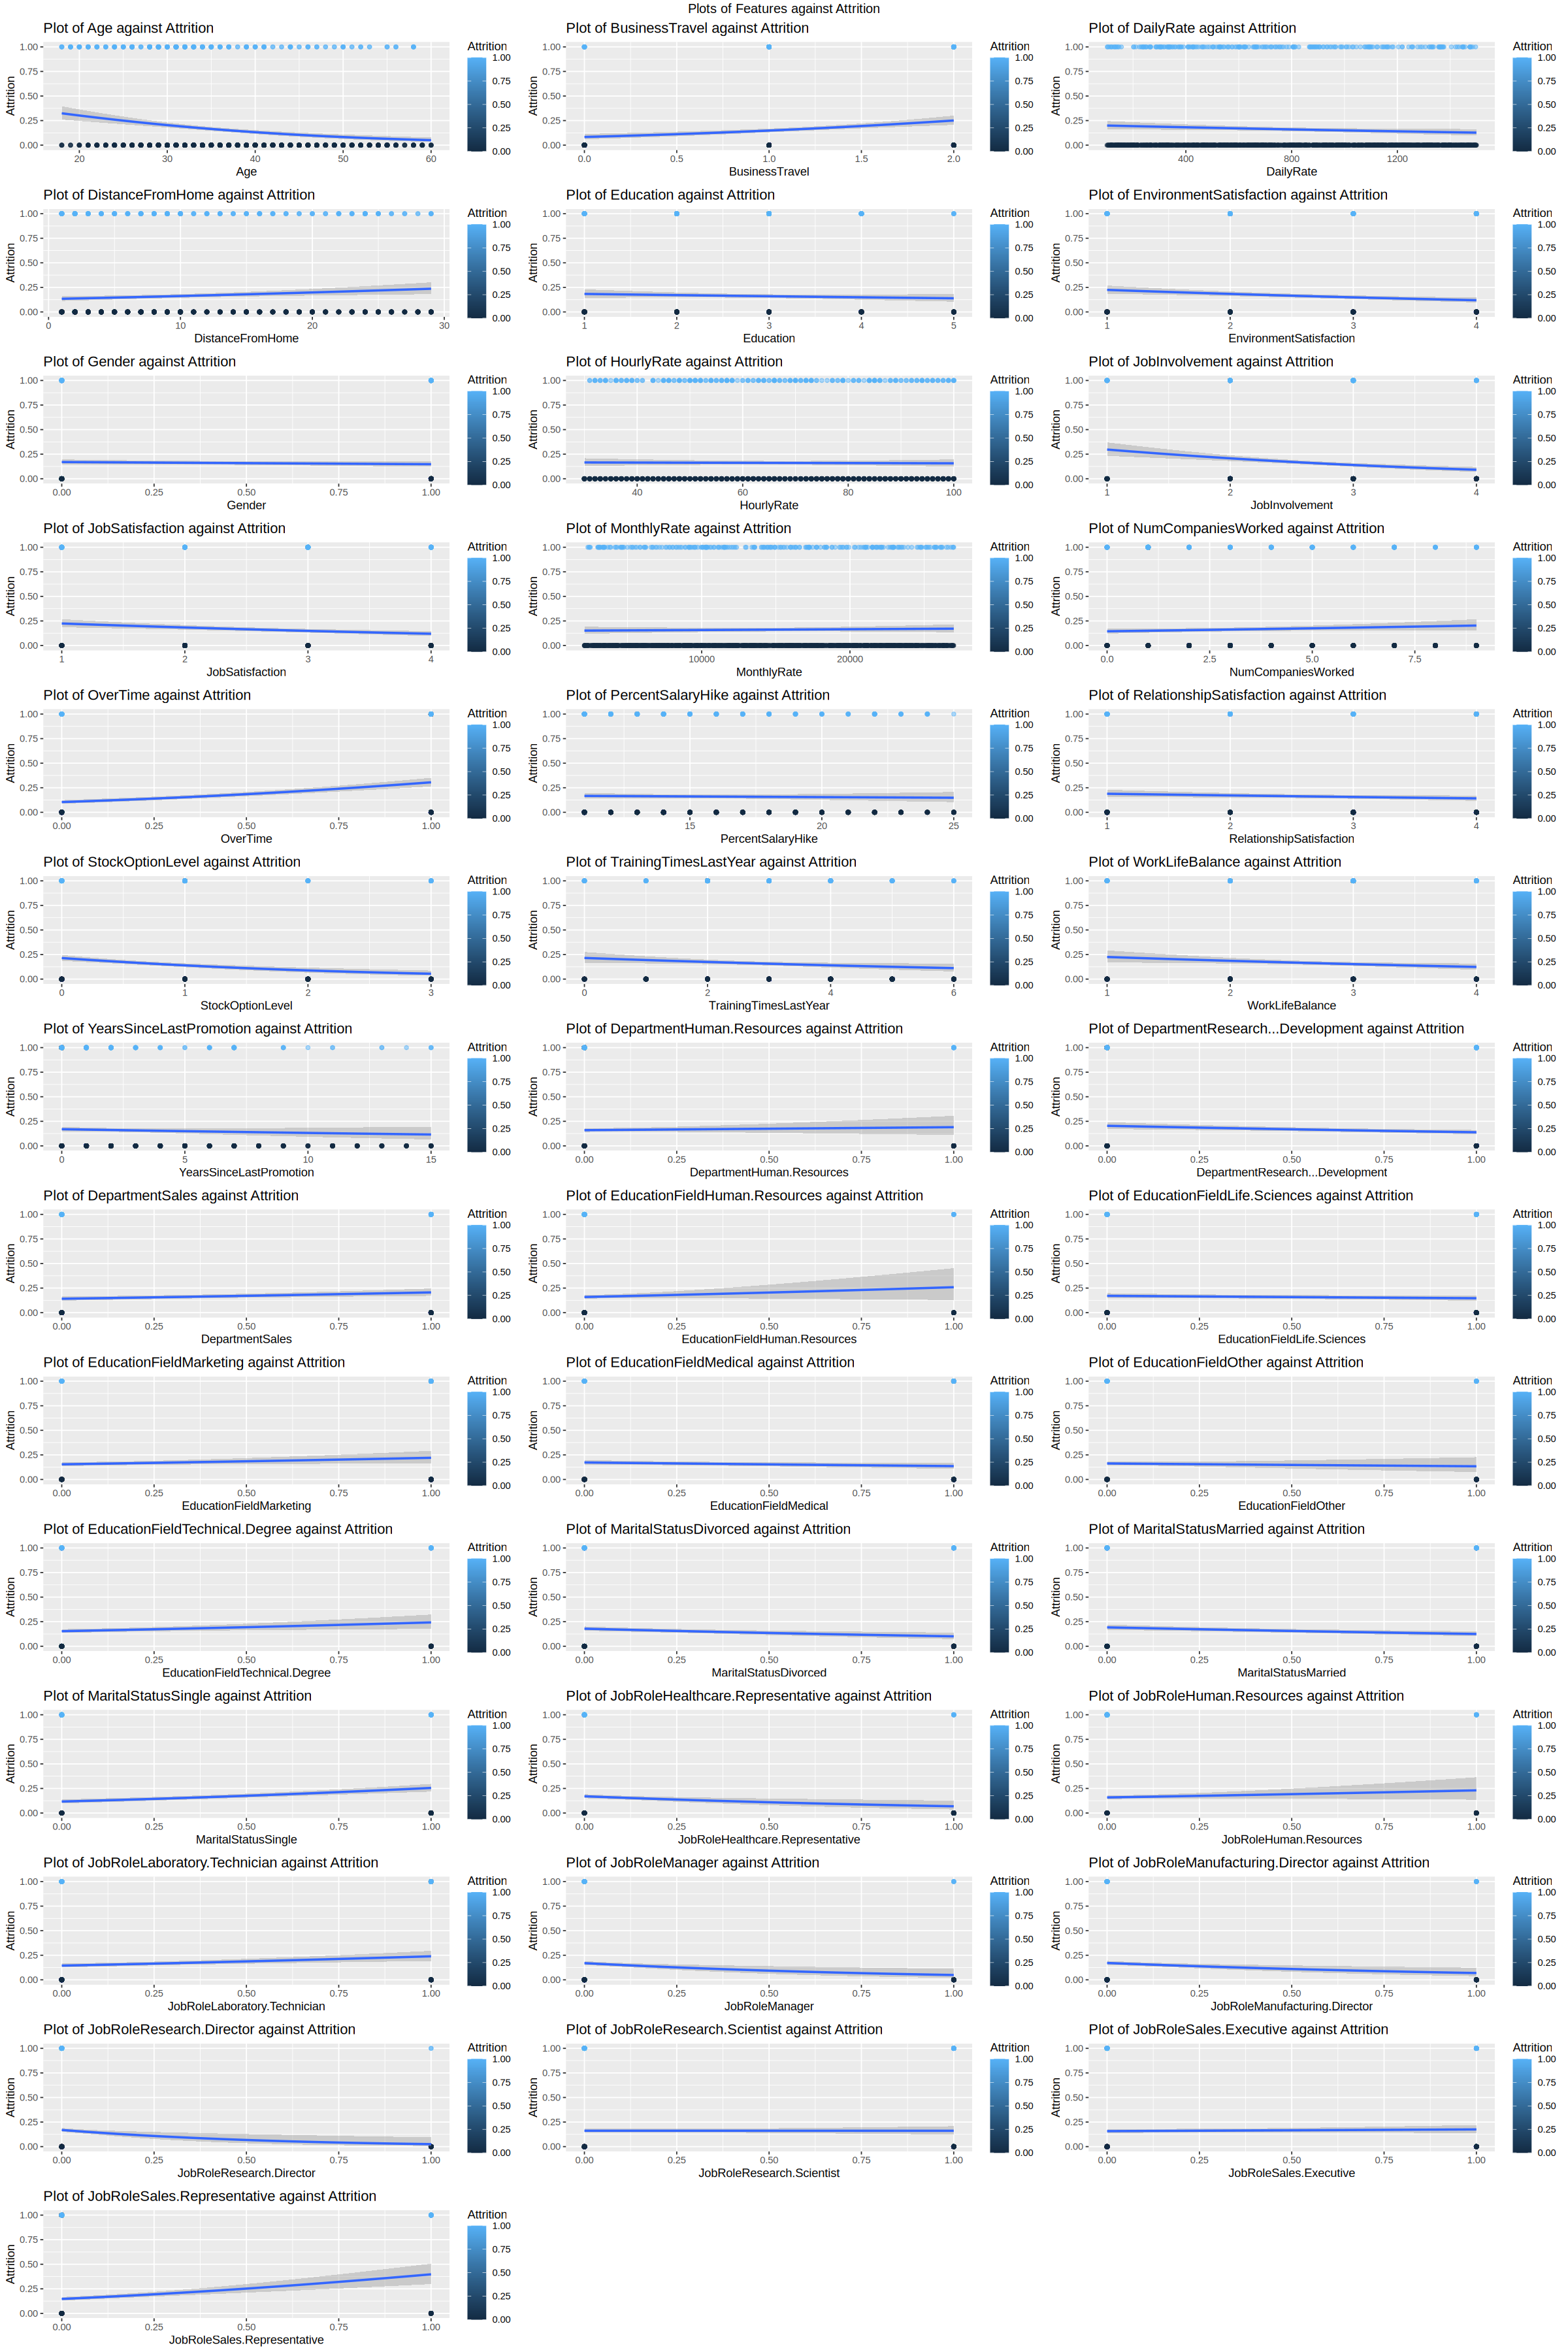

In [13]:
plot_test_set <- model_dataset
# sum(ifelse(plot_test_set$Attrition == 1 | plot_test_set$Attrition == 0, 0, 1))

plot_test_set$Attrition <- as.numeric(plot_test_set$Attrition) - 1
# unique(plot_test_set$Attrition)

library(gridExtra)

plots <- list()

for (feature in names(plot_test_set)) {
  if (feature != "Attrition") {
    plot <- ggplot(plot_test_set, aes_string(x = feature, y = "Attrition")) +
      geom_point(aes(color = Attrition), alpha = 0.5) +
      geom_smooth(method = "glm", method.args = list(family = "binomial"), formula = y ~ x) +
      labs(title = paste("Plot of", feature, "against Attrition"))
    
    plots[[feature]] <- plot
  }
}

options(repr.plot.width=20, repr.plot.height=30)

grid.arrange(grobs = plots, ncol = 3, top = "Plots of Features against Attrition")


In [39]:
set.seed(100)
split_ratio <- sample.split(model_dataset, SplitRatio = 0.7)

training_set <-  subset(model_dataset, split_ratio=="TRUE")
testing_set <- subset(model_dataset, split_ratio=="FALSE")

In [40]:
filter_outliers <- function(data, feature, low_bound = -1, high_bound = 1, rm_attrition_status = "both") {
     if (low_bound != -1 && high_bound != -1) {
                if (rm_attrition_status == "both") {
                        return(data[data[, feature] > low_bound & data[, feature] < high_bound, ])
                } else {
                        return(data[(data[, feature] > low_bound & data[, feature] < high_bound & data$Attrition == rm_attrition_status) | data$Attrition != rm_attrition_status, ])
                }
        } else {
                outliers <- boxplot(data[, feature], plot = FALSE)$out
                return(data[!data[, feature] %in% outliers, ])
        }
}

# Removing outliers
training_set <- filter_outliers(training_set, "Age", 18, 60)


In [41]:
head(training_set)

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobSatisfaction,⋯,MaritalStatusSingle,JobRoleHealthcare.Representative,JobRoleHuman.Resources,JobRoleLaboratory.Technician,JobRoleManager,JobRoleManufacturing.Director,JobRoleResearch.Director,JobRoleResearch.Scientist,JobRoleSales.Executive,JobRoleSales.Representative
,<int>,<fct>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,41,1,1,1102,1,2,2,1,3,4,⋯,1,0,0,0,0,0,0,0,1,0
2,49,0,2,279,8,1,3,0,2,2,⋯,0,0,0,0,0,0,0,1,0,0
3,37,1,1,1373,2,2,4,0,2,3,⋯,1,0,0,1,0,0,0,0,0,0
4,33,0,2,1392,3,4,4,1,3,3,⋯,0,0,0,0,0,0,0,1,0,0
5,27,0,1,591,2,1,1,0,3,2,⋯,0,0,0,1,0,0,0,0,0,0
6,32,0,2,1005,2,2,4,0,3,4,⋯,1,0,0,1,0,0,0,0,0,0


In [42]:
lr_model <- logistic_reg() %>%
    set_engine("glm") %>%
    set_mode("classification") %>%
    fit(Attrition ~ ., data = training_set)


tidy(lr_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.066689e+00,1.107737e+00,5.47664873,4.334565e-08
Age,-3.968607e-02,1.450487e-02,-2.73605096,6.218140e-03
BusinessTravel,9.048217e-01,2.055035e-01,4.40294986,1.067889e-05
DailyRate,-3.914551e-04,2.613158e-04,-1.49801516,1.341293e-01
DistanceFromHome,4.378891e-02,1.214070e-02,3.60678689,3.100121e-04
Education,6.435059e-02,1.058678e-01,0.60783921,5.432941e-01
EnvironmentSatisfaction,-4.084177e-01,9.709926e-02,-4.20618756,2.597147e-05
Gender,-2.441531e-01,2.170746e-01,-1.12474292,2.606980e-01
JobInvolvement,-5.522264e-01,1.414171e-01,-3.90494851,9.424545e-05


In [43]:
prediction_results <- predict(lr_model, new_data=testing_set, type = "class")
prediction_results <- prediction_results$.pred_class

# Confusion Matrix
result_matrix <- table(testing_set$Attrition, prediction_results)
confusionMatrix(result_matrix)


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


Confusion Matrix and Statistics

   prediction_results
      0   1
  0 367   8
  1  42  33
                                          
               Accuracy : 0.8889          
                 95% CI : (0.8561, 0.9164)
    No Information Rate : 0.9089          
    P-Value [Acc > NIR] : 0.9368          
                                          
                  Kappa : 0.5114          
                                          
 Mcnemar's Test P-Value : 3.058e-06       
                                          
            Sensitivity : 0.8973          
            Specificity : 0.8049          
         Pos Pred Value : 0.9787          
         Neg Pred Value : 0.4400          
             Prevalence : 0.9089          
         Detection Rate : 0.8156          
   Detection Prevalence : 0.8333          
      Balanced Accuracy : 0.8511          
                                          
       'Positive' Class : 0               
                                          

In [44]:
# Accuracy automator

lr_dataset <- model_dataset

test_seeds <- seq(1, 100)

seed_len <- length(test_seeds)
overall_accuracy <- 0
max_accuracy <- 0
min_accuracy <- -1

for (curr_seed in test_seeds){
    set.seed(curr_seed)
    
    split_ratio <- sample.split(lr_dataset, SplitRatio = 0.7)

    training_set <-  subset(lr_dataset, split_ratio=="TRUE")
    testing_set <- subset(lr_dataset, split_ratio=="FALSE")
    
    lr_model <- logistic_reg() %>%
    set_engine("glm") %>%
    set_mode("classification") %>%
    fit(Attrition ~ ., data = training_set)

    prediction_results <- predict(lr_model, new_data=testing_set, type="class")
    prediction_results <- prediction_results$.pred_class

    matrix <- table(testing_set$Attrition, prediction_results)
    cm <- confusionMatrix(matrix)
    curr_accuracy <- cm$overall["Accuracy"]
    
    if (min_accuracy < 0 | min_accuracy > curr_accuracy){
        min_accuracy <- curr_accuracy
    }
    
    if (max_accuracy < curr_accuracy){
        max_accuracy <- curr_accuracy
    }
    
    overall_accuracy <- overall_accuracy + curr_accuracy
}
overall_accuracy <- (overall_accuracy/seed_len)*100
max_accuracy <- max_accuracy * 100
min_accuracy <- min_accuracy * 100

print(paste("Overall Accuracy:", sprintf("%.2f%%", overall_accuracy)))
print(paste("Accuracy range: (", sprintf("%.2f%%", min_accuracy), "-", sprintf("%.2f%%", max_accuracy), ")"))

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning me

[1] "Overall Accuracy: 87.18%"
[1] "Accuracy range: ( 84.77% - 90.71% )"
